Dataset loaded successfully!
Missing values manually added for analysis!

Missing values per column:
 location       0
carpet_area    6
bed_room       0
kitchen        0
living_room    0
dining_room    0
toilet         0
balcony        0
price          0
dtype: int64

Head of preprocessed data:
    carpet_area  bed_room  kitchen  living_room  dining_room  toilet  balcony  \
0       4100.0       3.0      1.0          1.0          1.0     2.0      1.0   
1       4100.0       2.0      1.0          1.0          0.0     1.0      0.0   
2       4100.0       6.0      1.0          1.0          1.0     5.0      4.0   
3       4100.0       4.0      1.0          1.0          1.0     3.0      2.0   
4       4100.0       3.0      1.0          1.0          1.0     2.0      1.0   

       price  location_Ahmedabad  location_Bangalore  ...  location_Patna  \
0  1300000.0                 0.0                 1.0  ...             0.0   
1   900000.0                 0.0                 0.0  ...           

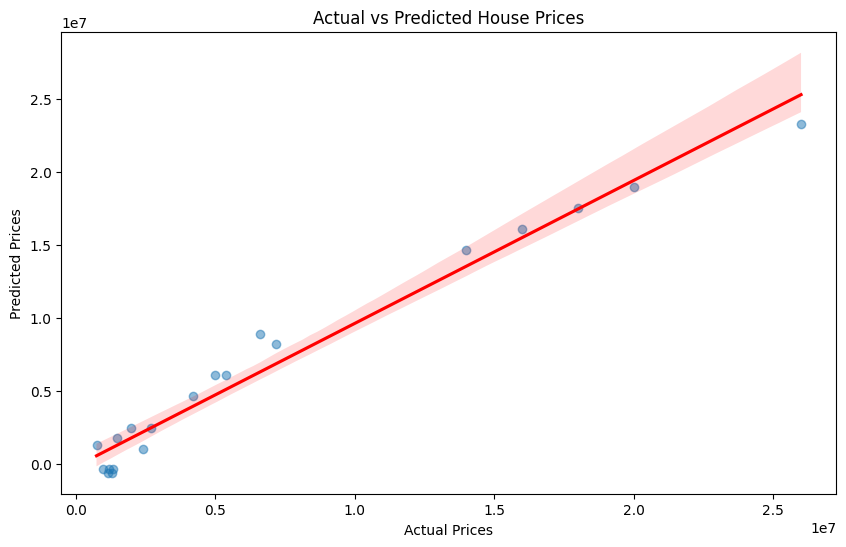


Success: 'model.pkl' has been generated for your Flask app!
Final features used for the model: ['carpet_area', 'bed_room', 'kitchen', 'living_room', 'dining_room', 'toilet']


In [4]:
# ==========================================
# BLG-407 MACHINE LEARNING - PROJECT 3
# NAME: [Your Name]
# ID: [Your ID]
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ---------------------------------------------------------
# 1. DATA LOADING
# ---------------------------------------------------------
# Replacing the dummy data with a real file load as per your assignment
# If your file is a CSV, use pd.read_csv('filename.csv')
try:
    df = pd.read_json('flat_prices.json')
    print("Dataset loaded successfully!")
except:
    print("File not found. Please upload House_Price.json to Colab.")

# ---------------------------------------------------------
# 2. DATA PREPROCESSING
# ---------------------------------------------------------

# A. Feature Selection: Keep only relevant features (Max 10)
# List the columns you want to keep here
df = df[['location', 'carpet_area', 'bed_room', 'kitchen', 'living_room' , 'dining_room'  , 'toilet' , 'balcony', 'price']] # Added 'price' here

# Manually inserting a few missing values for the sake of the project requirement
df.loc[0:5, 'carpet_area'] = np.nan  # Makes the first 5 rows of 'Area' empty

print("Missing values manually added for analysis!")

# B. Missing Values Analysis
print("\nMissing values per column:\n", df.isnull().sum())

# Strategy: Filling missing numerical values with Median
# 1. Create an imputer object that will replace missing values (NaN) with the median value of each column.
imputer = SimpleImputer(strategy='median')

# 2. Identify and create a list of all column names in the dataframe that contain numerical data (integers or floats).
numerical_cols = df.select_dtypes(include=[np.number]).columns

# 3. Calculate the median for those columns, fill the missing spots, and update the dataframe with the new complete values.
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# C. Categorical Data Encoding (One-Hot Encoding)
# 1. Converts categorical (text) columns into multiple new columns containing only 0 and 1.
# 'drop_first=True' removes the first category to avoid a mathematical error called the 'Dummy Variable Trap.'
df = pd.get_dummies(df, drop_first=True)

# 2. Converts all data in the entire table (Dataframe) into 'float' (decimal numbers).
# This ensures consistency so the model doesn't get confused between integers and decimals.
df = df.astype(float)

print("\nHead of preprocessed data:\n", df.head())

# ---------------------------------------------------------
# 3. BACKWARD ELIMINATION
#we eliminate the statistically unnecessary attributes with backward_elimination function.
#to do that, we calculate the p value, and if p>0.05 , we eliminate that attribute
# ---------------------------------------------------------

X = df.drop(columns=['price']) # eliminates price and looks at the other attributes (the attributes we want to learn from)
y = df['price']                # it's what we want to predict

# Add constant for statsmodels OLS
X = sm.add_constant(X)

def backward_elimination(data, target, significance_level=0.05):
    features = data.columns.tolist()
    while len(features) > 0:
        model = sm.OLS(target, data[features]).fit()
        p_values = model.pvalues

        # We protect 'carpet_area' and 'const' so they are NEVER considered for removal.
        # This prevents the model from losing its scale and predicting negative prices.
        p_values_to_check = p_values.drop(labels=['const', 'carpet_area'], errors='ignore')

        if len(p_values_to_check) == 0:
            break

        max_p_value = p_values_to_check.max()
        if max_p_value > significance_level:
            excluded_feature = p_values_to_check.idxmax()
            features.remove(excluded_feature)
            print(f"Removed: {excluded_feature} (P-Value: {max_p_value:.4f})")
        else:
            break
    return data[features], model

X_opt, final_reg_model = backward_elimination(X, y)
print("\nFinal selected features after Backward Elimination:", X_opt.columns.tolist())

# ---------------------------------------------------------
# 4. MODEL TRAINING & EVALUATION
# ---------------------------------------------------------

# Remove the 'const' column for sklearn training
# Use 'errors=ignore' so it doesn't crash if 'const' was already removed by Backward Elimination
X_final = X_opt.drop(columns=['const'], errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predictions
y_pred = regressor.predict(X_test)

# Metrics
print("\n--- MODEL METRICS ---")
print(f"R-Squared: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.2f}")

# Visualization
plt.figure(figsize=(10,6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()

# ---------------------------------------------------------
# 5. SAVING THE MODEL (.PKL)
# ---------------------------------------------------------

with open('model.pkl', 'wb') as file:
    pickle.dump(regressor, file)

print("\nSuccess: 'model.pkl' has been generated for your Flask app!")
print("Final features used for the model:", X_final.columns.tolist())